In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import gc
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras.backend as K

import cv2

import open3d as o3

from functools import partial

from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split

from fastai.vision import Path
from keras.models import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
clip180 = partial(np.clip, a_min=-3.14, a_max=3.14)
clip90 = partial(np.clip, a_min=0., a_max=1.57)

In [4]:
def show_pcd_3d(x_data, save=False, name=None):
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(x_data))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = x_data[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')
        ax.set_title(idx)
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_pcd.png')


def show_match_result(pred, tar, save=False, name=None):
    '''
    pcd shape must have dimension of number of pcd, 
    like (num, x, x, x, 3), (num, -1), (num, -1, 3)
    '''
    assert len(pred) == len(tar)
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(tar))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = tar[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')

        data = pred[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]
        ax.scatter(x, y, z, c='b', marker='o')

        ax.set_title(f'index: {idx}, RMS: {eva_rms(pred[idx], tar[idx]):.2f}')
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_match_result.png')

In [5]:
def eva_rms(pred, tar):
    pred_tmp = pred.reshape(-1)
    tar_tmp = tar.reshape(-1)
    assert pred_tmp.shape == tar_tmp.shape

    return np.sqrt(np.mean((pred_tmp - tar_tmp)**2))

In [6]:
def q_norm(q):
    return np.sum(np.square(q))


def q_inv(q):
    invq = np.array([-q[0], -q[1], -q[2], q[3]]) / q_norm(q)
    return invq


def q_mut(q1, q2):
    assert len(q1) == 4 == len(q2)
    a1, b1, c1, d1 = q1
    a2, b2, c2, d2 = q2
    
    qw = (a1 * a2 - b1 * b2 - c1 * c2 - d1 * d2)
    qx = (a1 * b2 + b1 * a2 + c1 * d2 - d1 * c2)
    qy = (a1 * c2 - b1 * d2 + c1 * a2 + d1 * b2)
    qz = (a1 * d2 + b1 * c2 - c1 * b2 + d1 * a2)
    
    return np.array([qw, qx, qy, qz])


def rotate_with_q(xyz, q):
    xyz_tmp = np.append(xyz, 0)
    q_tmp = q_mut(q, q_mut(xyz_tmp, q_inv(q)))
    return q_tmp[:3]

In [7]:
def z_norm(x, max_x, min_x):
    norm = (x - min_x) / (max_x - min_x)
    return np.float32(norm)

In [8]:
def show_match_result(pred, tar, save=False, name=None):
    '''
    pcd shape must have dimension of number of pcd, 
    like (num, x, x, x, 3), (num, -1), (num, -1, 3)
    '''
    assert len(pred) == len(tar)
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(tar))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = tar[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')

        data = pred[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]
        ax.scatter(x, y, z, c='b', marker='o')

        ax.set_title(f'index: {idx}, RMS: {eva_rms(pred[idx], tar[idx]):.2f}')
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_match_result.png')

In [9]:
def invQ(q):
    absQ = np.sum(np.square(q))
    invq = np.array([-q[0], -q[1], -q[2], q[3]]) / absQ
    return invq


def rm2theta(rm):
    eps = 1e-16
    theta2 = np.arctan2(rm[0, 2], np.sqrt(np.power(rm[0, 0], 2) + np.power(rm[0, 1], 2)))
    theta1 = np.arctan2(-rm[1, 2]/ (np.cos(theta2)), rm[2, 2]/ (np.cos(theta2)) )
    theta3 = np.arctan2(-rm[0, 1]/ (np.cos(theta2)), rm[0, 0]/(np.cos(theta2)))
    
    theta1 = clip180(theta1)
    theta2 = clip90(theta2)
    theta3 = clip180(theta3)
    
    return np.array([theta1, theta2, theta3])


def theta2rm(theta):   
    theta1, theta2, theta3 = theta
    
    rm = np.zeros((3,3))
    rm[0,0] = math.cos(theta2) * math.cos(theta3)
    rm[0,1] = -math.cos(theta2) * math.sin(theta3)
    rm[0,2] = math.sin(theta2)
    
    rm[1,0] = math.cos(theta1) * math.sin(theta3) + math.cos(theta3) * math.sin(theta1) * math.sin(theta2)
    rm[1,1] = math.cos(theta1) * math.cos(theta3) - math.sin(theta1) * math.sin(theta2) * math.sin(theta3)
    rm[1,2] = -math.cos(theta2) * math.sin(theta1)
    
    rm[2,0] = math.sin(theta1) * math.sin(theta3) - math.cos(theta1) * math.cos(theta3) * math.sin(theta2)
    rm[2,1] = math.cos(theta3) * math.sin(theta1) + math.cos(theta1) * math.sin(theta2) * math.sin(theta3)
    rm[2,2] = math.cos(theta1) * math.cos(theta2)

    return rm


def rm2Quaternion(rm):
    qw = np.sqrt(1 + rm[0, 0] + rm[1, 1] + rm[2, 2]) / 2
    qx = (rm[2, 1] - rm[1, 2]) / (4 * qw)
    qy = (rm[0, 2] - rm[2, 0]) / (4 * qw)
    qz = (rm[1, 0] - rm[0, 1]) / (4 * qw)

    return np.array([qw, qx, qy, qz])


def quaternion2rm(q):
    q = q / np.linalg.norm(q)
    rm = np.zeros((3, 3))
    rm[0, 0] = 1 - 2 * q[2]**2 - 2 * q[3]**2
    rm[0, 1] = 2 * q[1] * q[2] - 2 * q[0] * q[3]
    rm[0, 2] = 2 * q[1] * q[3] + 2 * q[0] * q[2]

    rm[1, 0] = 2 * q[1] * q[2] + 2 * q[0] * q[3]
    rm[1, 1] = 1 - 2 * q[1]**2 - 2 * q[3]**2
    rm[1, 2] = 2 * q[2] * q[3] - 2 * q[0] * q[1]

    rm[2, 0] = 2 * q[1] * q[3] - 2 * q[0] * q[2]
    rm[2, 1] = 2 * q[2] * q[3] + 2 * q[0] * q[1]
    rm[2, 2] = 1 - 2 * q[1]**2 - 2 * q[2]**2

    return rm


def quaternion2xyz(q):
    q0 = q[:, 0:1]
    q1 = q[:, 1:2]
    q2 = q[:, 2:3]
    q3 = q[:, 3:]

    theta1 = np.arctan2(2 * (q0 * q1 + q2 * q3), 1 - 2 * (q1**2 + q2**2))
    theta2 = np.arcsin(2 * (q0 * q2 - q3 * q1))
    theta3 = np.arctan2(2 * (q0 * q3 + q1 * q2), 1 - 2 * (q2**2 + q3**3))
    
    return np.concatenate([theta1, theta2, theta3], axis=-1)    

In [10]:
def getCore(data):
    coreTmp = np.zeros((1, 3))
    coreTmp[:, 0] = np.sum(data[:, ::3], axis=1) / (data.shape[1] / 3)   #coreX
    coreTmp[:, 1] = np.sum(data[:, 1::3], axis=1) / (data.shape[1] / 3)  #coreY
    coreTmp[:, 2] = np.sum(data[:, 2::3], axis=1) / (data.shape[1] / 3)  #coreZ

    return coreTmp


def dataShift(data, core):    #使全部點剛好在第一象限
    data[:, ::3] = data[:, ::3] - core[0, 0]
    data[:, 1::3] = data[:, 1::3] - core[0, 1]
    data[:, 2::3] = data[:, 2::3] - core[0, 2]

    xShiftTmp = min(data[0, ::3])
    yShiftTmp = min(data[0, 1::3])
    zShiftTmp = min(data[0, 2::3])

    data[:, ::3] = data[:, ::3] - xShiftTmp
    data[:, 1::3] = data[:, 1::3] - yShiftTmp
    data[:, 2::3] = data[:, 2::3] - zShiftTmp

    return data


def getMaxRadius(data):
    maxTmp = 0
    indexTmp = 0

    for i in range(data.shape[1] // 3):
        tmp = np.sqrt(np.square(data[0, i*3]) + np.square(data[0, i*3 + 1]) + np.square(data[0, i*3 + 2]))
        if (tmp  > maxTmp):
            maxTmp = tmp
            indexTmp = i    

    return indexTmp, maxTmp


def getAABBSize(rdata):  
    xTmp = rdata[0, ::3]
    yTmp = rdata[0, 1::3]
    zTmp = rdata[0, 2::3]

    xDis = max(xTmp) - min(xTmp)
    yDis = max(yTmp) - min(yTmp)
    zDis = max(zTmp) - min(zTmp) 

    return xDis, yDis, zDis


def get3DMatrix(xDis, yDis, zDis, rData):
    MCount = np.zeros((mSize, mSize, mSize))
    MCount = MCount + 1e-7    #避免除零    
    MResult = np.zeros((mSize, mSize, mSize * 3))    #三通道
    MXSum = np.zeros((mSize, mSize, mSize))
    MYSum = np.zeros((mSize, mSize, mSize))
    MZSum = np.zeros((mSize, mSize, mSize))

    for i in range (rData.shape[1] // 3):
        D1Tmp = math.floor(rData[0, i*3] / xDis * mSize)
        D2Tmp = math.floor(rData[0, i*3 + 1] / yDis * mSize)
        D3Tmp = math.floor(rData[0, i*3 + 2] / zDis * mSize)
        
        D1Tmp = np.minimum(12, D1Tmp)
        D2Tmp = np.minimum(12, D2Tmp)
        D3Tmp = np.minimum(12, D3Tmp)
        
        D1Tmp = np.maximum(-12, D1Tmp)
        D2Tmp = np.maximum(-12, D2Tmp)
        D3Tmp = np.maximum(-12, D3Tmp)

        if D1Tmp != mSize and D2Tmp != mSize and D3Tmp != mSize:
            MCount[D1Tmp, D2Tmp, D3Tmp] = MCount[D1Tmp, D2Tmp, D3Tmp] + 1
            MXSum[D1Tmp, D2Tmp, D3Tmp] = MXSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3]
            MYSum[D1Tmp, D2Tmp, D3Tmp] = MYSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 1]
            MZSum[D1Tmp, D2Tmp, D3Tmp] = MZSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 2]
        else:
            D1Tmp = D1Tmp - 1 if D1Tmp == mSize else D1Tmp
            D2Tmp = D2Tmp - 1 if D2Tmp == mSize else D2Tmp
            D3Tmp = D3Tmp - 1 if D3Tmp == mSize else D3Tmp

            MCount[D1Tmp, D2Tmp, D3Tmp] = MCount[D1Tmp, D2Tmp, D3Tmp] + 1
            MXSum[D1Tmp, D2Tmp, D3Tmp] = MXSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3]
            MYSum[D1Tmp, D2Tmp, D3Tmp] = MYSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 1]
            MZSum[D1Tmp, D2Tmp, D3Tmp] = MZSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 2]
            
    MXSum = np.divide(MXSum, MCount)
    MYSum = np.divide(MYSum, MCount)
    MZSum = np.divide(MZSum, MCount)

    for i in range(mSize):
        MResult[:, :, i * 3] = MXSum[:, :, i]
        MResult[:, :, i * 3 + 1] = MYSum[:, :, i]
        MResult[:, :, i * 3 + 2] = MZSum[:, :, i]

    return MResult    

In [11]:
def eva_rms(pred, tar):
    pred_tmp = pred.reshape(-1)
    tar_tmp = tar.reshape(-1)
    assert pred_tmp.shape == tar_tmp.shape

    return np.sqrt(np.mean((pred_tmp - tar_tmp)**2))

In [12]:
def seperate_labels(data, dev_set=True, delete_data=True):
    # assert (data.shape[1] - 3) % 3 == 0
    mSize = 12

    if dev_set == False:
        x_data = data[:, :-4].reshape(data.shape[0], mSize, mSize, mSize, 3)
        y_data = data[:, -4:]
        
        if delete_data ==True:
            del data
            gc.collect()
            
        return x_data, y_data

    else:
        x_data = data[:, :-4].reshape(data.shape[0], mSize, mSize, mSize, 3)
        y_data = data[:, -4:]
        x_train, x_dev, y_train, y_dev = train_test_split(
            x_data, y_data, test_size=0.1, random_state=1)
        
        if delete_data ==True:
            del data
            gc.collect()
            
        return x_train, x_dev, y_train, y_dev

In [13]:
def get_files_names(path):
    fnames=[]
    for idx, name in enumerate(path.ls()):
        if name.suffix == '.txt':
            fnames.append(name)
    return fnames

In [14]:
def show_pcd_3d(x_data, save=False, name='123'):
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(x_data))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = x_data[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')
        ax.set_title(idx)
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_pcd.png')

In [15]:
def scalar_reduction(x_hat, x_max, x_min):
    reduction = x_hat * (x_max - x_min) + x_min
    return np.float32(reduction)

In [94]:
# load and saveing path
print("Load path: \n")
load_path = Path('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/')
load_path.ls(), len(load_path.ls())

Load path: 



([WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_points_1253.pcd'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_points_1253.txt'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_points_3135.pcd'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_points_3135.txt'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_test_9000.txt'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_train_50000.txt'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000__1728.txt'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bunny_train_30000.txt'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datas

In [106]:
fname = get_files_names(load_path)
fname 

[WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_points_1253.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_points_3135.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_test_9000.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_train_50000.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000__1728.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bunny_train_30000.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/normali_test.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/normal_socket_test_9000.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/featur

In [96]:
fname[3]

WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bunny_train_30000.txt')

In [107]:
train_raw =  np.loadtxt(fname[3]) 


In [108]:
test_raw =  np.loadtxt(fname[2])

In [109]:
train_raw.shape, test_raw.shape

((50000, 5188), (9000, 5188))

In [110]:
x_train, x_dev, y_train, y_dev = seperate_labels(train_raw)

In [111]:
x_train.shape, x_dev.shape, y_train.shape, y_dev.shape

((45000, 12, 12, 12, 3), (5000, 12, 12, 12, 3), (45000, 4), (5000, 4))

In [112]:
x_test, y_test = seperate_labels(test_raw, dev_set=False)

In [113]:
x_test.shape, y_test.shape

((9000, 12, 12, 12, 3), (9000, 4))

In [114]:
def z_norm(x, max_x, min_x):
    norm = (x - min_x) / (max_x - min_x)
    return np.float32(norm)

In [115]:
x_train_max = np.max(x_train)
x_train_min = np.min(x_train)


In [116]:
np.savez(f'{fname[0].stem}_q_scalar.npz', xmax=x_train_max, xmin=x_train_min, volsz=0.006)

In [117]:
np.max(x_train), np.min(x_train), np.std(x_train), np.median(x_train), np.mean(x_train)

(0.10432491739334268,
 -0.09656911365814234,
 0.013908125592389005,
 0.0,
 3.60248554423709e-05)

In [118]:
x_train = z_norm(x_train, x_train_max, x_train_min)
np.max(x_train), np.min(x_train), np.std(x_train), np.median(x_train), np.mean(x_train)

(1.0, 0.0, 0.06923127, 0.48069677, 0.48087725)

In [119]:
x_dev = z_norm(x_dev, x_train_max, x_train_min)

In [120]:
np.max(x_test), np.min(x_test), np.std(x_test), np.median(x_test), np.mean(x_test)

(0.10432385569641797,
 -0.09656551581173013,
 0.013900448870274576,
 0.0,
 3.992815147513797e-05)

In [121]:
x_test = z_norm(x_test, x_train_max, x_train_min)
np.max(x_test), np.min(x_test), np.std(x_test), np.median(x_test), np.mean(x_test)

(0.9999947, 1.7909175e-05, 0.069192916, 0.48069677, 0.48089516)

In [122]:
np.max(y_train), np.min(y_train)

(0.999997460002087, 0.0)

In [123]:
def cnn_model(input_shape=(12, 12, 12, 3)):
    inputs = Input(shape=input_shape)
    
    #  第一層
    C1 = Conv3D(32, (5, 5, 5), padding='same', name='conv3d_1', kernel_initializer='glorot_normal')(inputs)
    C1 = BatchNormalization(name='batch_normalization_c1')(C1)
    C11 = Activation('relu')(C1)
    
    # 第二層
    C1 = Conv3D(32, (3, 3, 3), padding='same', name='conv2d_2', kernel_initializer='glorot_normal')(C11)
    C1 = BatchNormalization(name='batch_normalization_c2')(C1)    
    C12 = Activation('relu')(C1)   
    
    # 接起來 1、2層，因為把Feature傳下去，效果為Loss function會變平滑，在硬體可以承受的範圍內可以無限加深、加速。Deeper and Deeper.
    Concat1 = concatenate([C11, C12])
    
    # 1*1*1的原因是因為接起來的參數太多，所以要壓扁，至於為什麼要這樣做自己去讀論文。
    Concat1 = Conv3D(16, (1, 1, 1), padding='same', name='conv3d_1x1_1', kernel_initializer='glorot_normal')(Concat1)
    # C1 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(Concat1)
    
    # 第三層
    C2 = Conv3D(64, (5, 5, 5), padding='same', name='conv3d_3', kernel_initializer='glorot_normal')(Concat1)
    C2 = BatchNormalization(name='batch_normalization_c3')(C2)
    C21 = Activation('relu')(C2)   
    
    # 接起來 壓扁
    Concat2 = concatenate([Concat1, C21])
    Concat2 = Conv3D(32, (1, 1, 1), padding='same', name='conv3d_1x1_2', kernel_initializer='glorot_normal')(Concat2)
    
    # 第四層
    C2 = Conv3D(64, (3, 3, 3), padding='same', name='conv3d_4', kernel_initializer='glorot_normal')(Concat2)
    C2 = BatchNormalization(name='batch_normalization_c4')(C2)
    C22 = Activation('relu')(C2)    

    # 接起來 壓扁
    Concat3 = concatenate([Concat2, C22])
    Concat3 = Conv3D(32, (1, 1, 1), padding='same', name='conv3d_1x1_3', kernel_initializer='glorot_normal')(Concat3)    
    
    C2 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(Concat3)
    
    # Global Average pooling3D 現在默認都用這個，原因自己查。
    C = GlobalAveragePooling3D(name='G_ave_pol')(C2)                         
    # C = Flatten()(C2)
    
    FC5 = Dense(256, activation='relu', name='dense_1', kernel_initializer='glorot_normal')(C)
    FC5 = BatchNormalization(name='batch_normalization_d1')(FC5)
    FC5 = Activation('relu')(FC5)
    # FC5 = Dropout(0.15)(FC5)
    
    Output = Dense(3, activation='relu', name='dense_3', kernel_initializer='glorot_normal')(FC5)
        
    model = Model(inputs=inputs, outputs=Output)
    
    return model

In [124]:
def cnn_model(input_shape=(12, 12, 12, 3)):
    inputs = Input(shape=input_shape)
    
    #  第一層
    C1 = Conv3D(32, (5, 5, 5), padding='same', name='conv3d_1', kernel_initializer='glorot_normal')(inputs)
    C1 = BatchNormalization(name='batch_normalization_c1')(C1)
    C11 = Activation('relu')(C1)
    
    # 第二層
    C1 = Conv3D(32, (3, 3, 3), padding='same', name='conv2d_2', kernel_initializer='glorot_normal')(C11)
    C1 = BatchNormalization(name='batch_normalization_c2')(C1)    
    C12 = Activation('relu')(C1)   
    
    # 接起來 1、2層，因為把Feature傳下去，效果為Loss function會變平滑，在硬體可以承受的範圍內可以無限加深、加速。Deeper and Deeper.
    Concat1 = concatenate([C11, C12])
    
    # 1*1*1的原因是因為接起來的參數太多，所以要壓扁，至於為什麼要這樣做自己去讀論文。
    Concat1 = Conv3D(16, (1, 1, 1), padding='same', name='conv3d_1x1_1', kernel_initializer='glorot_normal')(Concat1)
    # C1 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(Concat1)
    
    # 第三層
    C2 = Conv3D(64, (5, 5, 5), padding='same', name='conv3d_3', kernel_initializer='glorot_normal')(Concat1)
    C2 = BatchNormalization(name='batch_normalization_c3')(C2)
    C21 = Activation('relu')(C2)   
    
    # 接起來 壓扁
    Concat2 = concatenate([Concat1, C21])
    Concat2 = Conv3D(32, (1, 1, 1), padding='same', name='conv3d_1x1_2', kernel_initializer='glorot_normal')(Concat2)
    
    # # 第四層
    # C2 = Conv3D(64, (3, 3, 3), padding='same', name='conv3d_4', kernel_initializer='glorot_normal')(Concat2)
    # C2 = BatchNormalization(name='batch_normalization_c4')(C2)
    # C22 = Activation('relu')(C2)    

    # # 接起來 壓扁
    # Concat3 = concatenate([Concat2, C22])
    # Concat3 = Conv3D(32, (1, 1, 1), padding='same', name='conv3d_1x1_3', kernel_initializer='glorot_normal')(Concat3)    
    
    C2 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(Concat2)
    
    # Global Average pooling3D 現在默認都用這個，原因自己查。
    C = GlobalAveragePooling3D(name='G_ave_pol')(C2)                         
    # C = Flatten()(C2)
    
    FC5 = Dense(256, activation='relu', name='dense_1', kernel_initializer='glorot_normal')(C)
    FC5 = BatchNormalization(name='batch_normalization_d1')(FC5)
    FC5 = Activation('relu')(FC5)
    # FC5 = Dropout(0.15)(FC5)
    
    Output = Dense(3, activation='relu', name='dense_3', kernel_initializer='glorot_normal')(FC5)
        
    model = Model(inputs=inputs, outputs=Output)
    
    return model

In [125]:
model = cnn_model()

In [126]:
model_checkpoint = ModelCheckpoint(f'{fname[0].stem}_callback_model.h5',verbose=1, monitor='val_mean_absolute_error',  mode='auto',save_best_only=True)

In [127]:
reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.5 ,patience=4, min_lr=1e-6, verbose=True)

In [128]:
# model.compile(optimizer=Adam(3e-4, decay=3e-5, amsgrad=True, clipnorm=1.), loss='mse', metrics=['accuracy', 'mse', 'mae']) 
model.compile(optimizer=SGD(3e-3, decay= 1e-7, momentum=0.9, nesterov=True), loss='mae', metrics=['accuracy', 'mse', 'mae']) 
# model.compile(optimizer=Adadelta(), loss='mse', metrics=['accuracy', 'mse', 'mae'])

In [129]:
%%time
history = model.fit(x = x_train, y = y_train[:, :3], batch_size = 512, epochs=60, verbose=1,
                    callbacks=[reduce_lr, model_checkpoint],
                    validation_data=(x_dev, y_dev[:, :3]))

Train on 45000 samples, validate on 5000 samples
Epoch 1/60
45000/45000 [==============================] - ETA: 1:25 - loss: 0.4413 - accuracy: 0.2852 - mse: 0.2747 - mae: 0.44 - ETA: 58s - loss: 0.4336 - accuracy: 0.2959 - mse: 0.2698 - mae: 0.4336 - ETA: 49s - loss: 0.4319 - accuracy: 0.2936 - mse: 0.2681 - mae: 0.431 - ETA: 44s - loss: 0.4245 - accuracy: 0.3008 - mse: 0.2621 - mae: 0.424 - ETA: 41s - loss: 0.4180 - accuracy: 0.3098 - mse: 0.2566 - mae: 0.418 - ETA: 39s - loss: 0.4108 - accuracy: 0.3298 - mse: 0.2505 - mae: 0.410 - ETA: 37s - loss: 0.3995 - accuracy: 0.3521 - mse: 0.2404 - mae: 0.399 - ETA: 36s - loss: 0.3894 - accuracy: 0.3721 - mse: 0.2313 - mae: 0.389 - ETA: 35s - loss: 0.3787 - accuracy: 0.3989 - mse: 0.2220 - mae: 0.378 - ETA: 34s - loss: 0.3686 - accuracy: 0.4248 - mse: 0.2134 - mae: 0.368 - ETA: 33s - loss: 0.3605 - accuracy: 0.4519 - mse: 0.2064 - mae: 0.360 - ETA: 32s - loss: 0.3529 - accuracy: 0.4767 - mse: 0.1997 - mae: 0.352 - ETA: 31s - loss: 0.3461 - ac

C:\Users\dreamer\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_mean_absolute_error` which is not available. Available metrics are: val_loss,val_accuracy,val_mse,val_mae,loss,accuracy,mse,mae,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
C:\Users\dreamer\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_mean_absolute_error available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/60
45000/45000 [==============================] - ETA: 31s - loss: 0.1172 - accuracy: 0.9355 - mse: 0.0269 - mae: 0.117 - ETA: 31s - loss: 0.1150 - accuracy: 0.9355 - mse: 0.0248 - mae: 0.115 - ETA: 31s - loss: 0.1127 - accuracy: 0.9342 - mse: 0.0237 - mae: 0.112 - ETA: 31s - loss: 0.1119 - accuracy: 0.9321 - mse: 0.0235 - mae: 0.111 - ETA: 31s - loss: 0.1124 - accuracy: 0.9355 - mse: 0.0240 - mae: 0.112 - ETA: 30s - loss: 0.1124 - accuracy: 0.9372 - mse: 0.0241 - mae: 0.112 - ETA: 30s - loss: 0.1117 - accuracy: 0.9392 - mse: 0.0242 - mae: 0.111 - ETA: 30s - loss: 0.1110 - accuracy: 0.9404 - mse: 0.0239 - mae: 0.111 - ETA: 29s - loss: 0.1117 - accuracy: 0.9421 - mse: 0.0241 - mae: 0.111 - ETA: 29s - loss: 0.1121 - accuracy: 0.9422 - mse: 0.0242 - mae: 0.112 - ETA: 28s - loss: 0.1123 - accuracy: 0.9409 - mse: 0.0242 - mae: 0.112 - ETA: 28s - loss: 0.1126 - accuracy: 0.9390 - mse: 0.0242 - mae: 0.112 - ETA: 28s - loss: 0.1124 - accuracy: 0.9384 - mse: 0.0241 - mae: 0.112 - ETA: 2

45000/45000 [==============================] - ETA: 32s - loss: 0.1053 - accuracy: 0.9590 - mse: 0.0218 - mae: 0.105 - ETA: 32s - loss: 0.1048 - accuracy: 0.9502 - mse: 0.0220 - mae: 0.104 - ETA: 31s - loss: 0.1051 - accuracy: 0.9518 - mse: 0.0221 - mae: 0.105 - ETA: 31s - loss: 0.1094 - accuracy: 0.9526 - mse: 0.0234 - mae: 0.109 - ETA: 31s - loss: 0.1093 - accuracy: 0.9492 - mse: 0.0235 - mae: 0.109 - ETA: 30s - loss: 0.1102 - accuracy: 0.9495 - mse: 0.0239 - mae: 0.110 - ETA: 30s - loss: 0.1099 - accuracy: 0.9501 - mse: 0.0237 - mae: 0.109 - ETA: 30s - loss: 0.1095 - accuracy: 0.9478 - mse: 0.0235 - mae: 0.109 - ETA: 29s - loss: 0.1096 - accuracy: 0.9484 - mse: 0.0236 - mae: 0.109 - ETA: 29s - loss: 0.1099 - accuracy: 0.9490 - mse: 0.0237 - mae: 0.109 - ETA: 28s - loss: 0.1096 - accuracy: 0.9478 - mse: 0.0235 - mae: 0.109 - ETA: 28s - loss: 0.1095 - accuracy: 0.9463 - mse: 0.0236 - mae: 0.109 - ETA: 28s - loss: 0.1097 - accuracy: 0.9455 - mse: 0.0237 - mae: 0.109 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.1051 - accuracy: 0.9668 - mse: 0.0231 - mae: 0.105 - ETA: 32s - loss: 0.1077 - accuracy: 0.9648 - mse: 0.0243 - mae: 0.107 - ETA: 31s - loss: 0.1077 - accuracy: 0.9629 - mse: 0.0236 - mae: 0.107 - ETA: 31s - loss: 0.1063 - accuracy: 0.9590 - mse: 0.0229 - mae: 0.106 - ETA: 31s - loss: 0.1062 - accuracy: 0.9625 - mse: 0.0229 - mae: 0.106 - ETA: 30s - loss: 0.1070 - accuracy: 0.9596 - mse: 0.0231 - mae: 0.107 - ETA: 30s - loss: 0.1067 - accuracy: 0.9584 - mse: 0.0228 - mae: 0.106 - ETA: 30s - loss: 0.1058 - accuracy: 0.9568 - mse: 0.0226 - mae: 0.105 - ETA: 29s - loss: 0.1058 - accuracy: 0.9579 - mse: 0.0226 - mae: 0.105 - ETA: 29s - loss: 0.1062 - accuracy: 0.9588 - mse: 0.0227 - mae: 0.106 - ETA: 28s - loss: 0.1060 - accuracy: 0.9586 - mse: 0.0226 - mae: 0.106 - ETA: 28s - loss: 0.1062 - accuracy: 0.9591 - mse: 0.0226 - mae: 0.106 - ETA: 28s - loss: 0.1062 - accuracy: 0.9596 - mse: 0.0226 - mae: 0.106 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.1043 - accuracy: 0.9512 - mse: 0.0214 - mae: 0.104 - ETA: 32s - loss: 0.1041 - accuracy: 0.9531 - mse: 0.0213 - mae: 0.104 - ETA: 32s - loss: 0.1023 - accuracy: 0.9525 - mse: 0.0204 - mae: 0.102 - ETA: 31s - loss: 0.1017 - accuracy: 0.9492 - mse: 0.0208 - mae: 0.101 - ETA: 31s - loss: 0.1031 - accuracy: 0.9492 - mse: 0.0212 - mae: 0.103 - ETA: 31s - loss: 0.1029 - accuracy: 0.9525 - mse: 0.0212 - mae: 0.102 - ETA: 30s - loss: 0.1033 - accuracy: 0.9542 - mse: 0.0214 - mae: 0.103 - ETA: 30s - loss: 0.1031 - accuracy: 0.9541 - mse: 0.0213 - mae: 0.103 - ETA: 30s - loss: 0.1030 - accuracy: 0.9562 - mse: 0.0211 - mae: 0.103 - ETA: 30s - loss: 0.1032 - accuracy: 0.9570 - mse: 0.0212 - mae: 0.103 - ETA: 29s - loss: 0.1032 - accuracy: 0.9545 - mse: 0.0212 - mae: 0.103 - ETA: 29s - loss: 0.1031 - accuracy: 0.9548 - mse: 0.0212 - mae: 0.103 - ETA: 28s - loss: 0.1031 - accuracy: 0.9543 - mse: 0.0213 - mae: 0.103 - ETA: 28s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.1099 - accuracy: 0.9609 - mse: 0.0247 - mae: 0.109 - ETA: 32s - loss: 0.1059 - accuracy: 0.9658 - mse: 0.0226 - mae: 0.105 - ETA: 31s - loss: 0.1058 - accuracy: 0.9609 - mse: 0.0222 - mae: 0.105 - ETA: 31s - loss: 0.1056 - accuracy: 0.9551 - mse: 0.0224 - mae: 0.105 - ETA: 31s - loss: 0.1066 - accuracy: 0.9578 - mse: 0.0228 - mae: 0.106 - ETA: 30s - loss: 0.1063 - accuracy: 0.9580 - mse: 0.0227 - mae: 0.106 - ETA: 30s - loss: 0.1057 - accuracy: 0.9593 - mse: 0.0226 - mae: 0.105 - ETA: 29s - loss: 0.1055 - accuracy: 0.9614 - mse: 0.0225 - mae: 0.105 - ETA: 29s - loss: 0.1053 - accuracy: 0.9614 - mse: 0.0225 - mae: 0.105 - ETA: 29s - loss: 0.1052 - accuracy: 0.9629 - mse: 0.0225 - mae: 0.105 - ETA: 28s - loss: 0.1055 - accuracy: 0.9627 - mse: 0.0224 - mae: 0.105 - ETA: 28s - loss: 0.1051 - accuracy: 0.9626 - mse: 0.0224 - mae: 0.105 - ETA: 28s - loss: 0.1047 - accuracy: 0.9618 - mse: 0.0222 - mae: 0.104 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.1075 - accuracy: 0.9727 - mse: 0.0229 - mae: 0.107 - ETA: 32s - loss: 0.1074 - accuracy: 0.9648 - mse: 0.0235 - mae: 0.107 - ETA: 31s - loss: 0.1056 - accuracy: 0.9635 - mse: 0.0230 - mae: 0.105 - ETA: 31s - loss: 0.1049 - accuracy: 0.9668 - mse: 0.0224 - mae: 0.104 - ETA: 31s - loss: 0.1044 - accuracy: 0.9664 - mse: 0.0221 - mae: 0.104 - ETA: 30s - loss: 0.1047 - accuracy: 0.9665 - mse: 0.0223 - mae: 0.104 - ETA: 30s - loss: 0.1051 - accuracy: 0.9665 - mse: 0.0228 - mae: 0.105 - ETA: 29s - loss: 0.1045 - accuracy: 0.9646 - mse: 0.0224 - mae: 0.104 - ETA: 29s - loss: 0.1041 - accuracy: 0.9638 - mse: 0.0222 - mae: 0.104 - ETA: 29s - loss: 0.1038 - accuracy: 0.9613 - mse: 0.0221 - mae: 0.103 - ETA: 28s - loss: 0.1043 - accuracy: 0.9593 - mse: 0.0223 - mae: 0.104 - ETA: 28s - loss: 0.1041 - accuracy: 0.9595 - mse: 0.0224 - mae: 0.104 - ETA: 28s - loss: 0.1044 - accuracy: 0.9593 - mse: 0.0225 - mae: 0.104 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.1044 - accuracy: 0.9648 - mse: 0.0223 - mae: 0.104 - ETA: 32s - loss: 0.1006 - accuracy: 0.9600 - mse: 0.0207 - mae: 0.100 - ETA: 31s - loss: 0.1034 - accuracy: 0.9538 - mse: 0.0220 - mae: 0.103 - ETA: 31s - loss: 0.1024 - accuracy: 0.9561 - mse: 0.0215 - mae: 0.102 - ETA: 31s - loss: 0.1036 - accuracy: 0.9590 - mse: 0.0221 - mae: 0.103 - ETA: 30s - loss: 0.1026 - accuracy: 0.9613 - mse: 0.0217 - mae: 0.102 - ETA: 30s - loss: 0.1028 - accuracy: 0.9604 - mse: 0.0218 - mae: 0.102 - ETA: 30s - loss: 0.1032 - accuracy: 0.9624 - mse: 0.0220 - mae: 0.103 - ETA: 29s - loss: 0.1029 - accuracy: 0.9618 - mse: 0.0217 - mae: 0.102 - ETA: 29s - loss: 0.1029 - accuracy: 0.9602 - mse: 0.0217 - mae: 0.102 - ETA: 29s - loss: 0.1027 - accuracy: 0.9606 - mse: 0.0216 - mae: 0.102 - ETA: 28s - loss: 0.1032 - accuracy: 0.9603 - mse: 0.0218 - mae: 0.103 - ETA: 28s - loss: 0.1033 - accuracy: 0.9599 - mse: 0.0218 - mae: 0.103 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.1087 - accuracy: 0.9648 - mse: 0.0234 - mae: 0.108 - ETA: 32s - loss: 0.1054 - accuracy: 0.9609 - mse: 0.0228 - mae: 0.105 - ETA: 31s - loss: 0.1051 - accuracy: 0.9674 - mse: 0.0226 - mae: 0.105 - ETA: 31s - loss: 0.1046 - accuracy: 0.9707 - mse: 0.0226 - mae: 0.104 - ETA: 31s - loss: 0.1044 - accuracy: 0.9648 - mse: 0.0224 - mae: 0.104 - ETA: 30s - loss: 0.1043 - accuracy: 0.9645 - mse: 0.0223 - mae: 0.104 - ETA: 30s - loss: 0.1046 - accuracy: 0.9632 - mse: 0.0225 - mae: 0.104 - ETA: 29s - loss: 0.1042 - accuracy: 0.9619 - mse: 0.0223 - mae: 0.104 - ETA: 29s - loss: 0.1036 - accuracy: 0.9627 - mse: 0.0221 - mae: 0.103 - ETA: 29s - loss: 0.1032 - accuracy: 0.9629 - mse: 0.0218 - mae: 0.103 - ETA: 29s - loss: 0.1038 - accuracy: 0.9624 - mse: 0.0220 - mae: 0.103 - ETA: 28s - loss: 0.1046 - accuracy: 0.9622 - mse: 0.0222 - mae: 0.104 - ETA: 28s - loss: 0.1042 - accuracy: 0.9623 - mse: 0.0221 - mae: 0.104 - ETA: 28s - loss: 

45000/45000 [==============================] - ETA: 33s - loss: 0.0999 - accuracy: 0.9727 - mse: 0.0222 - mae: 0.099 - ETA: 32s - loss: 0.0990 - accuracy: 0.9756 - mse: 0.0209 - mae: 0.099 - ETA: 31s - loss: 0.0993 - accuracy: 0.9701 - mse: 0.0208 - mae: 0.099 - ETA: 31s - loss: 0.0993 - accuracy: 0.9727 - mse: 0.0210 - mae: 0.099 - ETA: 31s - loss: 0.1000 - accuracy: 0.9715 - mse: 0.0211 - mae: 0.100 - ETA: 30s - loss: 0.0998 - accuracy: 0.9701 - mse: 0.0209 - mae: 0.099 - ETA: 30s - loss: 0.1003 - accuracy: 0.9704 - mse: 0.0210 - mae: 0.100 - ETA: 30s - loss: 0.1011 - accuracy: 0.9722 - mse: 0.0212 - mae: 0.101 - ETA: 29s - loss: 0.1017 - accuracy: 0.9724 - mse: 0.0215 - mae: 0.101 - ETA: 29s - loss: 0.1023 - accuracy: 0.9723 - mse: 0.0219 - mae: 0.102 - ETA: 29s - loss: 0.1023 - accuracy: 0.9725 - mse: 0.0218 - mae: 0.102 - ETA: 28s - loss: 0.1019 - accuracy: 0.9720 - mse: 0.0215 - mae: 0.101 - ETA: 28s - loss: 0.1021 - accuracy: 0.9715 - mse: 0.0217 - mae: 0.102 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 33s - loss: 0.0984 - accuracy: 0.9727 - mse: 0.0214 - mae: 0.098 - ETA: 32s - loss: 0.0976 - accuracy: 0.9697 - mse: 0.0197 - mae: 0.097 - ETA: 32s - loss: 0.0980 - accuracy: 0.9655 - mse: 0.0200 - mae: 0.098 - ETA: 32s - loss: 0.0980 - accuracy: 0.9639 - mse: 0.0199 - mae: 0.098 - ETA: 32s - loss: 0.1002 - accuracy: 0.9633 - mse: 0.0208 - mae: 0.100 - ETA: 31s - loss: 0.1006 - accuracy: 0.9652 - mse: 0.0212 - mae: 0.100 - ETA: 31s - loss: 0.1014 - accuracy: 0.9637 - mse: 0.0214 - mae: 0.101 - ETA: 30s - loss: 0.1014 - accuracy: 0.9656 - mse: 0.0214 - mae: 0.101 - ETA: 30s - loss: 0.1017 - accuracy: 0.9659 - mse: 0.0215 - mae: 0.101 - ETA: 29s - loss: 0.1020 - accuracy: 0.9660 - mse: 0.0217 - mae: 0.102 - ETA: 29s - loss: 0.1017 - accuracy: 0.9664 - mse: 0.0217 - mae: 0.101 - ETA: 28s - loss: 0.1017 - accuracy: 0.9658 - mse: 0.0216 - mae: 0.101 - ETA: 28s - loss: 0.1024 - accuracy: 0.9654 - mse: 0.0219 - mae: 0.102 - ETA: 28s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.1072 - accuracy: 0.9570 - mse: 0.0231 - mae: 0.107 - ETA: 32s - loss: 0.1024 - accuracy: 0.9668 - mse: 0.0218 - mae: 0.102 - ETA: 31s - loss: 0.1022 - accuracy: 0.9661 - mse: 0.0219 - mae: 0.102 - ETA: 31s - loss: 0.1035 - accuracy: 0.9653 - mse: 0.0223 - mae: 0.103 - ETA: 31s - loss: 0.1030 - accuracy: 0.9648 - mse: 0.0220 - mae: 0.103 - ETA: 30s - loss: 0.1038 - accuracy: 0.9619 - mse: 0.0223 - mae: 0.103 - ETA: 30s - loss: 0.1034 - accuracy: 0.9632 - mse: 0.0221 - mae: 0.103 - ETA: 29s - loss: 0.1022 - accuracy: 0.9631 - mse: 0.0215 - mae: 0.102 - ETA: 29s - loss: 0.1019 - accuracy: 0.9614 - mse: 0.0213 - mae: 0.101 - ETA: 29s - loss: 0.1019 - accuracy: 0.9625 - mse: 0.0213 - mae: 0.101 - ETA: 28s - loss: 0.1023 - accuracy: 0.9627 - mse: 0.0213 - mae: 0.102 - ETA: 28s - loss: 0.1024 - accuracy: 0.9619 - mse: 0.0214 - mae: 0.102 - ETA: 28s - loss: 0.1026 - accuracy: 0.9620 - mse: 0.0215 - mae: 0.102 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.1089 - accuracy: 0.9492 - mse: 0.0250 - mae: 0.108 - ETA: 32s - loss: 0.1048 - accuracy: 0.9521 - mse: 0.0235 - mae: 0.104 - ETA: 31s - loss: 0.1029 - accuracy: 0.9557 - mse: 0.0226 - mae: 0.102 - ETA: 31s - loss: 0.1024 - accuracy: 0.9604 - mse: 0.0222 - mae: 0.102 - ETA: 31s - loss: 0.1022 - accuracy: 0.9621 - mse: 0.0220 - mae: 0.102 - ETA: 30s - loss: 0.1022 - accuracy: 0.9642 - mse: 0.0218 - mae: 0.102 - ETA: 30s - loss: 0.1022 - accuracy: 0.9651 - mse: 0.0220 - mae: 0.102 - ETA: 29s - loss: 0.1019 - accuracy: 0.9663 - mse: 0.0217 - mae: 0.101 - ETA: 29s - loss: 0.1021 - accuracy: 0.9668 - mse: 0.0220 - mae: 0.102 - ETA: 29s - loss: 0.1019 - accuracy: 0.9664 - mse: 0.0219 - mae: 0.101 - ETA: 28s - loss: 0.1014 - accuracy: 0.9672 - mse: 0.0217 - mae: 0.101 - ETA: 28s - loss: 0.1015 - accuracy: 0.9666 - mse: 0.0216 - mae: 0.101 - ETA: 28s - loss: 0.1015 - accuracy: 0.9668 - mse: 0.0217 - mae: 0.101 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.1019 - accuracy: 0.9570 - mse: 0.0212 - mae: 0.101 - ETA: 31s - loss: 0.0991 - accuracy: 0.9600 - mse: 0.0201 - mae: 0.099 - ETA: 31s - loss: 0.1004 - accuracy: 0.9648 - mse: 0.0208 - mae: 0.100 - ETA: 31s - loss: 0.1010 - accuracy: 0.9658 - mse: 0.0212 - mae: 0.101 - ETA: 31s - loss: 0.1011 - accuracy: 0.9645 - mse: 0.0210 - mae: 0.101 - ETA: 31s - loss: 0.1017 - accuracy: 0.9622 - mse: 0.0212 - mae: 0.101 - ETA: 30s - loss: 0.1010 - accuracy: 0.9629 - mse: 0.0209 - mae: 0.101 - ETA: 30s - loss: 0.1010 - accuracy: 0.9653 - mse: 0.0210 - mae: 0.101 - ETA: 29s - loss: 0.1013 - accuracy: 0.9664 - mse: 0.0210 - mae: 0.101 - ETA: 29s - loss: 0.1022 - accuracy: 0.9664 - mse: 0.0215 - mae: 0.102 - ETA: 29s - loss: 0.1023 - accuracy: 0.9666 - mse: 0.0215 - mae: 0.102 - ETA: 28s - loss: 0.1022 - accuracy: 0.9676 - mse: 0.0215 - mae: 0.102 - ETA: 28s - loss: 0.1017 - accuracy: 0.9686 - mse: 0.0214 - mae: 0.101 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.1037 - accuracy: 0.9629 - mse: 0.0225 - mae: 0.103 - ETA: 31s - loss: 0.1009 - accuracy: 0.9658 - mse: 0.0218 - mae: 0.100 - ETA: 31s - loss: 0.1032 - accuracy: 0.9648 - mse: 0.0227 - mae: 0.103 - ETA: 31s - loss: 0.1029 - accuracy: 0.9683 - mse: 0.0226 - mae: 0.102 - ETA: 31s - loss: 0.1037 - accuracy: 0.9684 - mse: 0.0232 - mae: 0.103 - ETA: 30s - loss: 0.1028 - accuracy: 0.9665 - mse: 0.0227 - mae: 0.102 - ETA: 30s - loss: 0.1014 - accuracy: 0.9674 - mse: 0.0220 - mae: 0.101 - ETA: 29s - loss: 0.1011 - accuracy: 0.9670 - mse: 0.0218 - mae: 0.101 - ETA: 29s - loss: 0.1007 - accuracy: 0.9666 - mse: 0.0217 - mae: 0.100 - ETA: 29s - loss: 0.1005 - accuracy: 0.9662 - mse: 0.0215 - mae: 0.100 - ETA: 28s - loss: 0.1007 - accuracy: 0.9652 - mse: 0.0216 - mae: 0.100 - ETA: 28s - loss: 0.1010 - accuracy: 0.9648 - mse: 0.0216 - mae: 0.101 - ETA: 28s - loss: 0.1010 - accuracy: 0.9644 - mse: 0.0217 - mae: 0.101 - ETA: 28s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.1054 - accuracy: 0.9707 - mse: 0.0261 - mae: 0.105 - ETA: 32s - loss: 0.1031 - accuracy: 0.9678 - mse: 0.0231 - mae: 0.103 - ETA: 32s - loss: 0.1012 - accuracy: 0.9674 - mse: 0.0222 - mae: 0.101 - ETA: 32s - loss: 0.1007 - accuracy: 0.9653 - mse: 0.0218 - mae: 0.100 - ETA: 32s - loss: 0.1000 - accuracy: 0.9648 - mse: 0.0216 - mae: 0.100 - ETA: 31s - loss: 0.0991 - accuracy: 0.9665 - mse: 0.0212 - mae: 0.099 - ETA: 31s - loss: 0.0992 - accuracy: 0.9682 - mse: 0.0212 - mae: 0.099 - ETA: 31s - loss: 0.1005 - accuracy: 0.9646 - mse: 0.0216 - mae: 0.100 - ETA: 31s - loss: 0.1010 - accuracy: 0.9653 - mse: 0.0216 - mae: 0.101 - ETA: 30s - loss: 0.1008 - accuracy: 0.9643 - mse: 0.0213 - mae: 0.100 - ETA: 30s - loss: 0.1008 - accuracy: 0.9641 - mse: 0.0213 - mae: 0.100 - ETA: 29s - loss: 0.1009 - accuracy: 0.9653 - mse: 0.0213 - mae: 0.100 - ETA: 29s - loss: 0.1005 - accuracy: 0.9659 - mse: 0.0212 - mae: 0.100 - ETA: 29s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.1008 - accuracy: 0.9707 - mse: 0.0211 - mae: 0.100 - ETA: 32s - loss: 0.1026 - accuracy: 0.9697 - mse: 0.0211 - mae: 0.102 - ETA: 32s - loss: 0.0991 - accuracy: 0.9694 - mse: 0.0202 - mae: 0.099 - ETA: 31s - loss: 0.0986 - accuracy: 0.9663 - mse: 0.0199 - mae: 0.098 - ETA: 31s - loss: 0.0982 - accuracy: 0.9676 - mse: 0.0196 - mae: 0.098 - ETA: 31s - loss: 0.0981 - accuracy: 0.9694 - mse: 0.0197 - mae: 0.098 - ETA: 30s - loss: 0.0988 - accuracy: 0.9682 - mse: 0.0199 - mae: 0.098 - ETA: 30s - loss: 0.0995 - accuracy: 0.9695 - mse: 0.0204 - mae: 0.099 - ETA: 30s - loss: 0.0994 - accuracy: 0.9696 - mse: 0.0206 - mae: 0.099 - ETA: 29s - loss: 0.0988 - accuracy: 0.9701 - mse: 0.0204 - mae: 0.098 - ETA: 29s - loss: 0.0988 - accuracy: 0.9700 - mse: 0.0204 - mae: 0.098 - ETA: 28s - loss: 0.0990 - accuracy: 0.9688 - mse: 0.0204 - mae: 0.099 - ETA: 28s - loss: 0.0989 - accuracy: 0.9700 - mse: 0.0204 - mae: 0.098 - ETA: 28s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.1004 - accuracy: 0.9766 - mse: 0.0215 - mae: 0.100 - ETA: 32s - loss: 0.1006 - accuracy: 0.9678 - mse: 0.0215 - mae: 0.100 - ETA: 31s - loss: 0.1008 - accuracy: 0.9694 - mse: 0.0219 - mae: 0.100 - ETA: 31s - loss: 0.1000 - accuracy: 0.9658 - mse: 0.0213 - mae: 0.100 - ETA: 31s - loss: 0.1003 - accuracy: 0.9648 - mse: 0.0212 - mae: 0.100 - ETA: 30s - loss: 0.1003 - accuracy: 0.9678 - mse: 0.0212 - mae: 0.100 - ETA: 30s - loss: 0.0999 - accuracy: 0.9693 - mse: 0.0208 - mae: 0.099 - ETA: 30s - loss: 0.1008 - accuracy: 0.9690 - mse: 0.0212 - mae: 0.100 - ETA: 29s - loss: 0.1011 - accuracy: 0.9683 - mse: 0.0213 - mae: 0.101 - ETA: 29s - loss: 0.1011 - accuracy: 0.9695 - mse: 0.0214 - mae: 0.101 - ETA: 28s - loss: 0.1011 - accuracy: 0.9696 - mse: 0.0214 - mae: 0.101 - ETA: 28s - loss: 0.1006 - accuracy: 0.9689 - mse: 0.0213 - mae: 0.100 - ETA: 28s - loss: 0.1012 - accuracy: 0.9680 - mse: 0.0216 - mae: 0.101 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.0976 - accuracy: 0.9766 - mse: 0.0196 - mae: 0.097 - ETA: 32s - loss: 0.0943 - accuracy: 0.9648 - mse: 0.0185 - mae: 0.094 - ETA: 31s - loss: 0.0950 - accuracy: 0.9668 - mse: 0.0190 - mae: 0.095 - ETA: 31s - loss: 0.0952 - accuracy: 0.9678 - mse: 0.0189 - mae: 0.095 - ETA: 31s - loss: 0.0963 - accuracy: 0.9688 - mse: 0.0193 - mae: 0.096 - ETA: 30s - loss: 0.0962 - accuracy: 0.9704 - mse: 0.0193 - mae: 0.096 - ETA: 30s - loss: 0.0965 - accuracy: 0.9674 - mse: 0.0197 - mae: 0.096 - ETA: 30s - loss: 0.0970 - accuracy: 0.9678 - mse: 0.0199 - mae: 0.097 - ETA: 29s - loss: 0.0968 - accuracy: 0.9683 - mse: 0.0197 - mae: 0.096 - ETA: 29s - loss: 0.0972 - accuracy: 0.9689 - mse: 0.0199 - mae: 0.097 - ETA: 28s - loss: 0.0971 - accuracy: 0.9675 - mse: 0.0198 - mae: 0.097 - ETA: 28s - loss: 0.0978 - accuracy: 0.9689 - mse: 0.0202 - mae: 0.097 - ETA: 28s - loss: 0.0976 - accuracy: 0.9691 - mse: 0.0201 - mae: 0.097 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.1019 - accuracy: 0.9648 - mse: 0.0212 - mae: 0.101 - ETA: 31s - loss: 0.1013 - accuracy: 0.9648 - mse: 0.0218 - mae: 0.101 - ETA: 31s - loss: 0.0997 - accuracy: 0.9688 - mse: 0.0217 - mae: 0.099 - ETA: 31s - loss: 0.0995 - accuracy: 0.9717 - mse: 0.0215 - mae: 0.099 - ETA: 30s - loss: 0.0986 - accuracy: 0.9711 - mse: 0.0210 - mae: 0.098 - ETA: 30s - loss: 0.0987 - accuracy: 0.9704 - mse: 0.0208 - mae: 0.098 - ETA: 30s - loss: 0.0988 - accuracy: 0.9696 - mse: 0.0208 - mae: 0.098 - ETA: 30s - loss: 0.0992 - accuracy: 0.9702 - mse: 0.0210 - mae: 0.099 - ETA: 29s - loss: 0.0987 - accuracy: 0.9696 - mse: 0.0208 - mae: 0.098 - ETA: 29s - loss: 0.0987 - accuracy: 0.9686 - mse: 0.0209 - mae: 0.098 - ETA: 29s - loss: 0.0988 - accuracy: 0.9686 - mse: 0.0209 - mae: 0.098 - ETA: 28s - loss: 0.0988 - accuracy: 0.9674 - mse: 0.0209 - mae: 0.098 - ETA: 28s - loss: 0.0987 - accuracy: 0.9678 - mse: 0.0209 - mae: 0.098 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 33s - loss: 0.1016 - accuracy: 0.9590 - mse: 0.0208 - mae: 0.101 - ETA: 32s - loss: 0.1000 - accuracy: 0.9629 - mse: 0.0205 - mae: 0.100 - ETA: 32s - loss: 0.0993 - accuracy: 0.9655 - mse: 0.0208 - mae: 0.099 - ETA: 32s - loss: 0.0984 - accuracy: 0.9653 - mse: 0.0204 - mae: 0.098 - ETA: 31s - loss: 0.0989 - accuracy: 0.9672 - mse: 0.0208 - mae: 0.098 - ETA: 31s - loss: 0.1001 - accuracy: 0.9668 - mse: 0.0213 - mae: 0.100 - ETA: 31s - loss: 0.1004 - accuracy: 0.9665 - mse: 0.0213 - mae: 0.100 - ETA: 30s - loss: 0.0997 - accuracy: 0.9668 - mse: 0.0211 - mae: 0.099 - ETA: 30s - loss: 0.1001 - accuracy: 0.9685 - mse: 0.0214 - mae: 0.100 - ETA: 29s - loss: 0.0993 - accuracy: 0.9691 - mse: 0.0212 - mae: 0.099 - ETA: 29s - loss: 0.0994 - accuracy: 0.9698 - mse: 0.0212 - mae: 0.099 - ETA: 29s - loss: 0.0993 - accuracy: 0.9689 - mse: 0.0212 - mae: 0.099 - ETA: 28s - loss: 0.0991 - accuracy: 0.9692 - mse: 0.0211 - mae: 0.099 - ETA: 28s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.0946 - accuracy: 0.9590 - mse: 0.0192 - mae: 0.094 - ETA: 32s - loss: 0.0974 - accuracy: 0.9648 - mse: 0.0200 - mae: 0.097 - ETA: 31s - loss: 0.0976 - accuracy: 0.9635 - mse: 0.0197 - mae: 0.097 - ETA: 31s - loss: 0.0980 - accuracy: 0.9648 - mse: 0.0198 - mae: 0.098 - ETA: 31s - loss: 0.0990 - accuracy: 0.9621 - mse: 0.0204 - mae: 0.099 - ETA: 30s - loss: 0.0976 - accuracy: 0.9655 - mse: 0.0199 - mae: 0.097 - ETA: 30s - loss: 0.0979 - accuracy: 0.9648 - mse: 0.0200 - mae: 0.097 - ETA: 30s - loss: 0.0971 - accuracy: 0.9641 - mse: 0.0198 - mae: 0.097 - ETA: 29s - loss: 0.0965 - accuracy: 0.9642 - mse: 0.0196 - mae: 0.096 - ETA: 29s - loss: 0.0965 - accuracy: 0.9656 - mse: 0.0197 - mae: 0.096 - ETA: 28s - loss: 0.0974 - accuracy: 0.9664 - mse: 0.0202 - mae: 0.097 - ETA: 28s - loss: 0.0968 - accuracy: 0.9668 - mse: 0.0200 - mae: 0.096 - ETA: 28s - loss: 0.0969 - accuracy: 0.9674 - mse: 0.0201 - mae: 0.096 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.0991 - accuracy: 0.9766 - mse: 0.0213 - mae: 0.099 - ETA: 31s - loss: 0.0954 - accuracy: 0.9736 - mse: 0.0196 - mae: 0.095 - ETA: 31s - loss: 0.0970 - accuracy: 0.9629 - mse: 0.0201 - mae: 0.097 - ETA: 31s - loss: 0.0994 - accuracy: 0.9648 - mse: 0.0211 - mae: 0.099 - ETA: 30s - loss: 0.0991 - accuracy: 0.9668 - mse: 0.0210 - mae: 0.099 - ETA: 30s - loss: 0.0982 - accuracy: 0.9645 - mse: 0.0208 - mae: 0.098 - ETA: 30s - loss: 0.0981 - accuracy: 0.9643 - mse: 0.0209 - mae: 0.098 - ETA: 29s - loss: 0.0981 - accuracy: 0.9641 - mse: 0.0208 - mae: 0.098 - ETA: 29s - loss: 0.0977 - accuracy: 0.9661 - mse: 0.0205 - mae: 0.097 - ETA: 29s - loss: 0.0978 - accuracy: 0.9674 - mse: 0.0205 - mae: 0.097 - ETA: 28s - loss: 0.0984 - accuracy: 0.9673 - mse: 0.0207 - mae: 0.098 - ETA: 28s - loss: 0.0986 - accuracy: 0.9676 - mse: 0.0208 - mae: 0.098 - ETA: 27s - loss: 0.0987 - accuracy: 0.9672 - mse: 0.0208 - mae: 0.098 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.0950 - accuracy: 0.9727 - mse: 0.0190 - mae: 0.095 - ETA: 32s - loss: 0.0965 - accuracy: 0.9697 - mse: 0.0201 - mae: 0.096 - ETA: 31s - loss: 0.0982 - accuracy: 0.9648 - mse: 0.0208 - mae: 0.098 - ETA: 31s - loss: 0.0992 - accuracy: 0.9678 - mse: 0.0211 - mae: 0.099 - ETA: 31s - loss: 0.0990 - accuracy: 0.9688 - mse: 0.0209 - mae: 0.099 - ETA: 31s - loss: 0.0991 - accuracy: 0.9684 - mse: 0.0207 - mae: 0.099 - ETA: 30s - loss: 0.0995 - accuracy: 0.9685 - mse: 0.0208 - mae: 0.099 - ETA: 30s - loss: 0.0996 - accuracy: 0.9695 - mse: 0.0208 - mae: 0.099 - ETA: 29s - loss: 0.0997 - accuracy: 0.9698 - mse: 0.0210 - mae: 0.099 - ETA: 29s - loss: 0.1000 - accuracy: 0.9691 - mse: 0.0212 - mae: 0.100 - ETA: 29s - loss: 0.0997 - accuracy: 0.9700 - mse: 0.0210 - mae: 0.099 - ETA: 28s - loss: 0.0992 - accuracy: 0.9707 - mse: 0.0208 - mae: 0.099 - ETA: 28s - loss: 0.0991 - accuracy: 0.9706 - mse: 0.0208 - mae: 0.099 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.0951 - accuracy: 0.9688 - mse: 0.0186 - mae: 0.095 - ETA: 32s - loss: 0.0967 - accuracy: 0.9668 - mse: 0.0199 - mae: 0.096 - ETA: 31s - loss: 0.0956 - accuracy: 0.9642 - mse: 0.0193 - mae: 0.095 - ETA: 31s - loss: 0.0966 - accuracy: 0.9648 - mse: 0.0194 - mae: 0.096 - ETA: 31s - loss: 0.0957 - accuracy: 0.9660 - mse: 0.0190 - mae: 0.095 - ETA: 30s - loss: 0.0970 - accuracy: 0.9655 - mse: 0.0196 - mae: 0.097 - ETA: 30s - loss: 0.0982 - accuracy: 0.9648 - mse: 0.0202 - mae: 0.098 - ETA: 29s - loss: 0.0975 - accuracy: 0.9675 - mse: 0.0199 - mae: 0.097 - ETA: 29s - loss: 0.0975 - accuracy: 0.9683 - mse: 0.0200 - mae: 0.097 - ETA: 29s - loss: 0.0982 - accuracy: 0.9668 - mse: 0.0203 - mae: 0.098 - ETA: 28s - loss: 0.0984 - accuracy: 0.9659 - mse: 0.0204 - mae: 0.098 - ETA: 28s - loss: 0.0979 - accuracy: 0.9666 - mse: 0.0201 - mae: 0.097 - ETA: 28s - loss: 0.0978 - accuracy: 0.9653 - mse: 0.0200 - mae: 0.097 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.1042 - accuracy: 0.9824 - mse: 0.0224 - mae: 0.104 - ETA: 32s - loss: 0.1001 - accuracy: 0.9678 - mse: 0.0208 - mae: 0.100 - ETA: 31s - loss: 0.0980 - accuracy: 0.9740 - mse: 0.0201 - mae: 0.098 - ETA: 31s - loss: 0.0990 - accuracy: 0.9746 - mse: 0.0207 - mae: 0.099 - ETA: 31s - loss: 0.0991 - accuracy: 0.9742 - mse: 0.0210 - mae: 0.099 - ETA: 30s - loss: 0.0982 - accuracy: 0.9753 - mse: 0.0205 - mae: 0.098 - ETA: 30s - loss: 0.0979 - accuracy: 0.9743 - mse: 0.0203 - mae: 0.097 - ETA: 30s - loss: 0.0978 - accuracy: 0.9741 - mse: 0.0203 - mae: 0.097 - ETA: 29s - loss: 0.0973 - accuracy: 0.9744 - mse: 0.0200 - mae: 0.097 - ETA: 29s - loss: 0.0974 - accuracy: 0.9744 - mse: 0.0200 - mae: 0.097 - ETA: 28s - loss: 0.0977 - accuracy: 0.9744 - mse: 0.0201 - mae: 0.097 - ETA: 28s - loss: 0.0975 - accuracy: 0.9743 - mse: 0.0201 - mae: 0.097 - ETA: 28s - loss: 0.0976 - accuracy: 0.9746 - mse: 0.0201 - mae: 0.097 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.0942 - accuracy: 0.9629 - mse: 0.0184 - mae: 0.094 - ETA: 32s - loss: 0.0975 - accuracy: 0.9600 - mse: 0.0204 - mae: 0.097 - ETA: 31s - loss: 0.1002 - accuracy: 0.9655 - mse: 0.0221 - mae: 0.100 - ETA: 31s - loss: 0.0996 - accuracy: 0.9673 - mse: 0.0218 - mae: 0.099 - ETA: 31s - loss: 0.0992 - accuracy: 0.9688 - mse: 0.0217 - mae: 0.099 - ETA: 30s - loss: 0.0988 - accuracy: 0.9701 - mse: 0.0214 - mae: 0.098 - ETA: 30s - loss: 0.0978 - accuracy: 0.9696 - mse: 0.0210 - mae: 0.097 - ETA: 30s - loss: 0.0980 - accuracy: 0.9702 - mse: 0.0209 - mae: 0.098 - ETA: 29s - loss: 0.0978 - accuracy: 0.9698 - mse: 0.0208 - mae: 0.097 - ETA: 29s - loss: 0.0977 - accuracy: 0.9699 - mse: 0.0206 - mae: 0.097 - ETA: 28s - loss: 0.0970 - accuracy: 0.9703 - mse: 0.0202 - mae: 0.097 - ETA: 28s - loss: 0.0973 - accuracy: 0.9704 - mse: 0.0203 - mae: 0.097 - ETA: 28s - loss: 0.0973 - accuracy: 0.9709 - mse: 0.0203 - mae: 0.097 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.1019 - accuracy: 0.9590 - mse: 0.0225 - mae: 0.101 - ETA: 32s - loss: 0.1015 - accuracy: 0.9580 - mse: 0.0222 - mae: 0.101 - ETA: 31s - loss: 0.0997 - accuracy: 0.9577 - mse: 0.0214 - mae: 0.099 - ETA: 31s - loss: 0.1003 - accuracy: 0.9619 - mse: 0.0218 - mae: 0.100 - ETA: 31s - loss: 0.0996 - accuracy: 0.9625 - mse: 0.0215 - mae: 0.099 - ETA: 30s - loss: 0.0978 - accuracy: 0.9622 - mse: 0.0208 - mae: 0.097 - ETA: 30s - loss: 0.0982 - accuracy: 0.9623 - mse: 0.0208 - mae: 0.098 - ETA: 30s - loss: 0.0983 - accuracy: 0.9639 - mse: 0.0208 - mae: 0.098 - ETA: 29s - loss: 0.0987 - accuracy: 0.9644 - mse: 0.0210 - mae: 0.098 - ETA: 29s - loss: 0.0979 - accuracy: 0.9650 - mse: 0.0206 - mae: 0.097 - ETA: 28s - loss: 0.0975 - accuracy: 0.9640 - mse: 0.0204 - mae: 0.097 - ETA: 28s - loss: 0.0975 - accuracy: 0.9652 - mse: 0.0204 - mae: 0.097 - ETA: 28s - loss: 0.0973 - accuracy: 0.9659 - mse: 0.0203 - mae: 0.097 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.0980 - accuracy: 0.9785 - mse: 0.0205 - mae: 0.098 - ETA: 31s - loss: 0.0961 - accuracy: 0.9775 - mse: 0.0195 - mae: 0.096 - ETA: 31s - loss: 0.0955 - accuracy: 0.9707 - mse: 0.0193 - mae: 0.095 - ETA: 31s - loss: 0.0953 - accuracy: 0.9722 - mse: 0.0193 - mae: 0.095 - ETA: 30s - loss: 0.0953 - accuracy: 0.9750 - mse: 0.0192 - mae: 0.095 - ETA: 30s - loss: 0.0973 - accuracy: 0.9730 - mse: 0.0201 - mae: 0.097 - ETA: 30s - loss: 0.0970 - accuracy: 0.9715 - mse: 0.0200 - mae: 0.097 - ETA: 29s - loss: 0.0960 - accuracy: 0.9714 - mse: 0.0197 - mae: 0.096 - ETA: 29s - loss: 0.0965 - accuracy: 0.9718 - mse: 0.0199 - mae: 0.096 - ETA: 29s - loss: 0.0967 - accuracy: 0.9730 - mse: 0.0200 - mae: 0.096 - ETA: 28s - loss: 0.0962 - accuracy: 0.9730 - mse: 0.0198 - mae: 0.096 - ETA: 28s - loss: 0.0960 - accuracy: 0.9733 - mse: 0.0198 - mae: 0.096 - ETA: 28s - loss: 0.0959 - accuracy: 0.9731 - mse: 0.0198 - mae: 0.095 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 32s - loss: 0.0930 - accuracy: 0.9785 - mse: 0.0189 - mae: 0.093 - ETA: 31s - loss: 0.0914 - accuracy: 0.9805 - mse: 0.0185 - mae: 0.091 - ETA: 31s - loss: 0.0941 - accuracy: 0.9785 - mse: 0.0190 - mae: 0.094 - ETA: 31s - loss: 0.0960 - accuracy: 0.9746 - mse: 0.0203 - mae: 0.096 - ETA: 30s - loss: 0.0953 - accuracy: 0.9734 - mse: 0.0198 - mae: 0.095 - ETA: 30s - loss: 0.0944 - accuracy: 0.9756 - mse: 0.0194 - mae: 0.094 - ETA: 30s - loss: 0.0943 - accuracy: 0.9757 - mse: 0.0195 - mae: 0.094 - ETA: 29s - loss: 0.0947 - accuracy: 0.9753 - mse: 0.0197 - mae: 0.094 - ETA: 29s - loss: 0.0947 - accuracy: 0.9733 - mse: 0.0196 - mae: 0.094 - ETA: 29s - loss: 0.0949 - accuracy: 0.9732 - mse: 0.0196 - mae: 0.094 - ETA: 28s - loss: 0.0950 - accuracy: 0.9728 - mse: 0.0196 - mae: 0.095 - ETA: 28s - loss: 0.0952 - accuracy: 0.9736 - mse: 0.0198 - mae: 0.095 - ETA: 28s - loss: 0.0956 - accuracy: 0.9740 - mse: 0.0199 - mae: 0.095 - ETA: 27s - loss: 

45000/45000 [==============================] - ETA: 34s - loss: 0.0960 - accuracy: 0.9727 - mse: 0.0218 - mae: 0.096 - ETA: 33s - loss: 0.0976 - accuracy: 0.9756 - mse: 0.0214 - mae: 0.097 - ETA: 33s - loss: 0.0967 - accuracy: 0.9766 - mse: 0.0208 - mae: 0.096 - ETA: 32s - loss: 0.0945 - accuracy: 0.9751 - mse: 0.0198 - mae: 0.094 - ETA: 32s - loss: 0.0944 - accuracy: 0.9746 - mse: 0.0197 - mae: 0.094 - ETA: 31s - loss: 0.0955 - accuracy: 0.9733 - mse: 0.0201 - mae: 0.095 - ETA: 31s - loss: 0.0955 - accuracy: 0.9729 - mse: 0.0202 - mae: 0.095 - ETA: 31s - loss: 0.0953 - accuracy: 0.9709 - mse: 0.0199 - mae: 0.095 - ETA: 30s - loss: 0.0958 - accuracy: 0.9696 - mse: 0.0201 - mae: 0.095 - ETA: 30s - loss: 0.0956 - accuracy: 0.9691 - mse: 0.0200 - mae: 0.095 - ETA: 29s - loss: 0.0960 - accuracy: 0.9696 - mse: 0.0201 - mae: 0.096 - ETA: 29s - loss: 0.0956 - accuracy: 0.9699 - mse: 0.0198 - mae: 0.095 - ETA: 28s - loss: 0.0959 - accuracy: 0.9701 - mse: 0.0199 - mae: 0.095 - ETA: 28s - loss: 

In [130]:
if not os.path.exists('models'):
    os.makedirs('models')

In [131]:
model.save(f'models/{fname[0].stem}_socket_model.h5')

In [132]:
model = load_model(f'models/{fname[0].stem}_socket_model.h5')

In [133]:
result = model.evaluate(x_train[:1000], y_train[:1000, :3] )
print('Accuracy of training Set:',result[1])
print('Loss of training set:', result[0])
print()
result_dev = model.evaluate(x_dev, y_dev[:, :3])
print('Accuracy of development set: ',result_dev[1])
print('Loss of development set:', result_dev[0])

1000/1000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 486us/step
Accuracy of training Set: 0.6990000009536743
Loss of training set: 0.18586388993263245

5000/5000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 349us/step
Accuracy of development set:  0.7242000102996826
Loss of development set: 0.1889767141342163


In [134]:
result, result_dev

([0.18586388993263245,
  0.6990000009536743,
  0.056084468960762024,
  0.1858639121055603],
 [0.1889767141342163,
  0.7242000102996826,
  0.05899885296821594,
  0.1889766901731491])

In [135]:
if not os.path.exists('results'):
    os.makedirs('results')

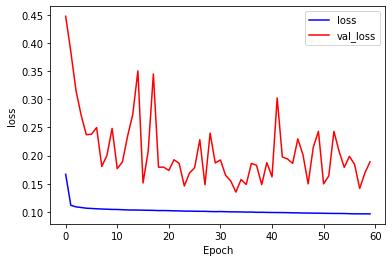

In [136]:
plt.plot( history.history['loss'], color = 'blue', label = 'loss')
plt.plot( history.history['val_loss'], color = 'red', label = 'val_loss')

# plt.plot( model.history['loss'], color = 'blue', label = 'loss')
# plt.plot( model.history['val_loss'], color = 'red', label = 'val_loss')

plt.legend(loc="best")
plt.ylabel('loss')
plt.xlabel('Epoch')
# plt.savefig(f'results/{fname.stem}_loss.png')
plt.show()

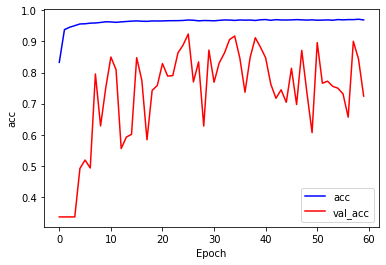

In [137]:
plt.plot( history.history['accuracy'], color = 'blue', label = 'acc')
plt.plot( history.history['val_accuracy'], color = 'red', label = 'val_acc')


plt.legend(loc="best")
plt.ylabel('acc')
plt.xlabel('Epoch')
# plt.savefig(f'results/{fname.stem}_acc.png')
plt.show()

In [138]:
result_test = model.evaluate(x_test, y_test[:, :3])
print('Accuracy of training Set:',result_test[1])
print('Loss of training set:', result_test[0])

9000/9000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 353us/step
Accuracy of training Set: 0.7279999852180481
Loss of training set: 0.19043788617187077


In [139]:
starttime = datetime.datetime.now()
y_pred = model.predict(x_test)
y_pred = np.concatenate([y_pred, np.full((len(y_test), 1), 0.)], axis=-1)
endtime = datetime.datetime.now()

print("Prediction %d samples execute time: %s sec" % (len(x_test), (endtime - starttime).total_seconds())) 
print("Average prediction execute time: %f ms" % ((endtime - starttime).total_seconds() / len(x_test) * 1000)) 

Prediction 9000 samples execute time: 3.04712 sec
Average prediction execute time: 0.338569 ms


In [140]:
successedT1 = 0
successedT2 = 0
successedT3 = 0
successedT4 = 0

maxofMax = 0
sumofMaxErr = 0
pred = None
errlist = []

for i in range(len(x_test)):
    
    if y_pred[i].any() == False:
        pred = np.full(3, 1e-16)
        pred = np.append(pred, 0.)
    else:
        pred = y_pred[i]
        
    estrm = quaternion2rm(pred)
    lbrm = quaternion2rm(y_test[i])
    errrm = estrm @ np.transpose(lbrm)
    
    err = rm2theta(errrm)
        
    maxErr = np.abs(np.max(err) / 3.14 * 180)


    
    errlist.append(maxErr)
    
    if maxErr > maxofMax:
        maxofMax = maxErr

    if maxErr < 0.5:
        successedT1 = successedT1 + 1
    if maxErr < 1:
        successedT2 = successedT2 + 1
    if maxErr < 1.75:
        successedT3 = successedT3 + 1
    if maxErr < 2.5:
        successedT4 = successedT4 + 1


    print(maxErr)
    sumofMaxErr = sumofMaxErr + maxErr


33.649378091560976
23.34151759253011
28.454570889240607
12.313110660444652
34.35866718262519
13.728727563266391
32.103733565545376
25.738512249961122
21.924797317761094
32.970328005750915
11.671258886511163
8.21259938394008
33.777144504741024
35.07881465218866
16.739481702847073
29.465379629493306
11.022564048446762
33.284465301512675
12.351291271224415
29.52471086134475
30.137093305951506
35.6036560828318
12.256048589490865
12.040742991557606
25.157479338687338
11.040873569183335
14.638854917484636
8.256874868818578
35.060116245409276
13.726270013667019
10.039212176505368
8.65429726306028
32.02184283326742
15.071626939564222
24.684129848177424
19.747092142411923
14.449596257604123
13.345691789866567
33.805347060046515
34.74056160492215
13.22586627338009
17.237133111756908
24.153101888393735
34.21376125373552
19.199572604876245
17.70337226144328
10.755690887350138
26.20771130496919
26.695273347847476
36.03264819455776
30.006060920759943
14.802631314421827
18.249533722279644
19.79909431

8.348938890663636
21.17098472845296
12.104401117788244
28.271386673197778
40.24458917828225
15.342415082857581
17.50294617775433
13.925671052265173
38.43471880853968
11.714378644595712
10.846895547177256
22.996773742316698
12.054527189128358
24.355313098255685
8.115172046857957
24.678664737896646
11.33597904635467
15.610666872815482
19.562046029202573
11.011301939986451
29.280317816369244
26.557484443101487
8.182858987846958
9.990557236374674
19.376126475850096
14.86300234065818
28.239048592752198
30.022468713524187
3.3699944856731583
36.813582021658824
23.80030709704629
31.21094312367059
16.798751356985587
17.58556680451792
47.31524565783897
20.141887402235444
32.571955834558
16.92365220855925
11.027677674003764
16.67393389231666
30.628481395106114
17.742056154217234
14.73128885740574
5.647477181147384
4.42902376213371
7.388529453316307
11.931973156817723
7.433670027490598
19.151190552635722
12.761005039722669
16.95439555718599
20.552139885740957
14.766551777990049
20.925963063379346


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



25.82473449278749
13.35329123749911
21.567158606546275
26.080587177971633
10.560256051733685
16.09513106051191
18.10889900753712
15.467431735364343
23.63022999197976
18.242414199465372
17.22524897398972
18.86364630556215
7.852198795974963
23.420155473373203
17.579382425443267
11.786453126767153
11.38689781990612
1.9072903992391326
7.101327274194495
9.828242654929658
22.1889742207155
20.706678825917507
28.127717728417483
15.439249289799893
14.73902682960844
29.960378054199666
8.453459214378242
34.77030641940318
22.579405500477694
7.317204990852918
32.18505728699647
11.514329412479642
7.95452460616224
25.942959276670024
10.846971536089782
19.26102632266522
12.358587064690692
40.403272488546975
9.109335826742855
10.028886483774555
18.119088060506822
31.29838972890763
44.023598770296
23.49190867669075
21.444043727948518
31.01117796506163
28.75727539982926
29.033811877880908
24.911860954634598
25.270307229970584
16.122695754437377
20.705541250869846
30.060478067236534
33.02329860461081
29.2

25.061696882318373
24.286687997549517
8.46856729003038
19.684649757942523
11.076185042268564
22.28908608058868
4.9874812102887365
11.817862228457464
21.31313084189883
13.986692124871846
6.185538860599425
18.752122662233777
33.353154979018264
15.748424929746726
16.19760675102438
41.93614848072334
15.802982005117148
28.75900599289787
27.753755310897024
5.53565676618657
9.193586495501195
8.688559999245832
21.798419712080392
29.689694317763323
10.971819302083363
14.506308747779716
22.9812626433466
5.332569402810923
28.28934705607304
17.413857178046783
12.226323607364431
14.51100428408022
32.763076506171615
27.198604444458997
17.303765962920846
31.390866075280503
18.985126533855755
20.320697803992736
35.367049359090764
6.80772381076219
27.230697797388537
35.05992804337409
11.845741371710515
14.802625216521896
15.432555987163568
40.25776378711803
12.462161091388483
24.670311193384805
21.097320155578903
18.526517798065868
16.72512534375729
21.81564390541613
7.828638736980956
24.97853619894284

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




18.81797831584253
23.1996036145634
7.305642580012286
4.712007515425226
9.888929985286191
22.228059005783557
14.850497675172926
19.83545074698353
27.24842893643498
19.220785266846814
25.852977813362106
30.473368653048556
8.839656198659537
26.892858177359813
16.027029984217016
14.926942144228088
12.430462967367687
25.433924525263333
26.57205798679167
28.903767334305766
25.372801508812564
32.84191139246219
34.48002616507506
25.156728734248244
41.54353568635085
11.590306848411517
21.888281946090586
35.52970007431264
19.114962817149298
3.649371551714157
50.29669055385094
24.313326385427253
27.106027796622442
28.68397955369366
13.874707218533166
22.344400420832507
6.250136463174853
13.891465681458525
25.771950382785906
32.74476870835584
11.19814736660334
22.895441025952827
20.29051709636829
10.069368237134677
28.441091664564887
32.621947747712156
23.568549039751435
8.019836757542391
12.488051446928983
3.907581435332371
18.78323196310087
12.17996692581049
29.151032200826734
7.202471672408270

17.581318857368686
28.84931742908086
31.511608246248674
29.152860255943008
37.32416719349487
27.375545874141697
37.838155898595986
33.82132576898603
15.397916636180938
25.33039877004413
3.5850372882428045
31.844439365298626
13.487209806125811
15.272485664075143
37.56155361147809
32.161820391568156
30.302427941124954
16.230255513520696
37.692488060726475
14.323117463851673
37.22782801688813
25.488221157331452
7.637625347823527
17.545407146437626
24.852013698042008
19.97867599734959
4.56738729961173
23.395410217658334
12.947725335645659
15.571327848212048
24.95919088172285
20.720012292936126
25.645596614190335
27.3627323753662
37.059568716517994
19.062501051365714
12.10429275904586
21.395726761613084
15.157130869245695
33.32164938589297
20.660800245958598
25.95958723562815
42.0640577370467
10.658133528431609
31.518284570240258
23.92350223922212
10.071022200830674
29.77769471833379
36.92862362654593
28.6778645563253
8.806386228272256
11.270933337617343
5.374407882833074
14.353518601411169

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




12.54937885435555
31.623460712514902
27.0686503915598
28.140853812635505
15.52061532040342
10.69758093416626
24.236946280020945
19.532148650195133
21.710704376310098
11.824195068288487
39.740557248181574
19.180686993569758
33.55283388819371
31.871324212327302
18.6367926163417
2.923565815814966
7.7931999852920795
36.32168033607511
36.32225218419313
2.63865597503355
35.98622794223788
18.699424288200387
25.596562732611332
6.936822883749392
24.076681941453945
25.93045484871645
13.719997195637765
39.00921130353438
51.85228525329016
11.532022231181784
18.530062927945277
31.766561549014874
30.689513199628642
22.85270933970591
9.019877392894891
17.819383274488207
6.747916114215995
40.97711763132796
14.884615429351387
12.968757768292921
33.19084830523107
25.08319009378621
33.76658618167938
23.549051666213696
18.328406227231806
35.348230867950896
16.89449429886493
20.284945651547115
26.255163763185518
8.798089806923764
11.593820680603981
25.14809117626941
27.21872020311388
34.089977590590145
19

4.554873440535743
11.71331793671276
14.921345107483061
24.455752578877064
25.83581077905609
15.830656268704715
11.623110015986908
5.844160027761769
21.59622141089524
11.178731001182422
15.707701789898556
21.381132048019374
9.912173727979312
3.5285212588405206
16.631117641853592
24.130736976825304
21.59350899758657
16.552589660997004
12.408615513276022
25.076178703243464
11.066016691608926
15.756960655147022
30.863725399374356
9.712334093101385
32.14556713313924
42.528724187144746
21.609782203833273
13.821502791092312
33.08007448941693
11.393657769280129
26.078656313456065
6.3191149775951265
19.98999040082578
14.336044256794843
12.61627465288857
9.46376725878192
11.710373141074125
36.72268452920846
30.447945980951292
10.902286016195541
15.027106921768892
13.17659893507977
30.28563579986795
12.152176224701575
27.743093655649098
4.168116507168887
6.566851582818868
18.516824620472164
8.379089760264575
14.654951186669177
15.048844403229063
27.854307869066254
17.570831172720954
10.9098365269

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [141]:
print('Max degree error: %.4f degrees' % maxofMax)
print('Average degree error: %.4f degrees' % (sumofMaxErr / len(y_test)))
print(' T1: %.2f \n T2: %.2f \n T3: %.2f \n T4: %.2f \n' 
      % (successedT1 / len(y_test) * 100, 
         successedT2 / len(y_test) * 100, 
         successedT3 / len(y_test) * 100, 
         successedT4 / len(y_test) * 100))

Max degree error: 59.3403 degrees
Average degree error: 20.7529 degrees
 T1: 0.14 
 T2: 0.27 
 T3: 0.57 
 T4: 1.11 



In [142]:
print("Prediction %d samples execute time: %s sec" % (len(x_test), (endtime - starttime).total_seconds())) 
print("Average prediction execute time: %f ms" % ((endtime - starttime).total_seconds() / len(x_test) * 1000)) 

Prediction 9000 samples execute time: 3.04712 sec
Average prediction execute time: 0.338569 ms


In [143]:
x_test_no_scalar = scalar_reduction(x_test, x_train_max, x_train_min)

# Appear the registration result between Whole and Partial
normal socket voxel number is 1 

In [144]:
load_whole_pcd = o3.read_point_cloud("/Users/dreamer/Warehouse/ibvs/data_generator/ori_test.pcd", "pcd")
# down_pcd = load_pcd

In [145]:
load_whole_pcd

geometry::PointCloud with 0 points.

In [146]:
mSize = 12
x_test_est = []
data = np.asarray(load_whole_pcd.points)
rotateData = data.copy()
starttime = datetime.datetime.now()


for i in range(len(x_test)):
    if y_pred[i].any() == False:
        pred = np.full(3, 1e-16)
        pred = np.append(pred, 0.)
    else:
        pred = y_pred[i]
        
    rotateData = data.copy()
    for n in range(len(data)):
        rotateData[n] = rotate_with_q(data[n], pred)
        
    rotateData = rotateData.reshape(1, -1)
          
    dis = getAABBSize(rotateData)

    result = get3DMatrix(dis[0], dis[1], dis[2], rotateData).reshape(-1)
    
    x_test_est.append(result.tolist())
    if i % 200 == 0:
        endtime = datetime.datetime.now()
        print("item %d execute time: %s" % (i, endtime - starttime))

x_test_est = np.array(x_test_est).reshape(len(x_test), -1, 3)

ValueError: max() arg is an empty sequence

## Appear single comparison

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

data = x_test_est[156].reshape(-1, 3)
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

ax.scatter(x, y, z, c='r', marker='o')

x_test_sample = x_test_no_scalar[156].reshape(-1, 3)
x = x_test_sample[:, 0]
y = x_test_sample[:, 1]
z = x_test_sample[:, 2]
ax.scatter(x, y, z, c='b', marker='o')

ax.set_title('original')


## Appear several comparations

In [ ]:
np.random.seed(0)
show_match_result(x_test_no_scalar[3:15], x_test_est[3:15], save=True, name="socket")

In [ ]:
rms = []
for i in range(len(x_test)):
    rms.append(eva_rms(x_test_no_scalar[i], x_test_est[i]))

print(f'Max RMS of socket testing data: {np.max(rms):.2f}')
print(f'Min RMS of socket testing data: {np.min(rms):.2f}')
print(f'Mean RMS of socket testing data: {np.mean(rms):.2f}')

In [ ]:
test = np.asarray(x_test_est[151])
np.savetxt("ori_test.txt", test)
source_pcd = o3.read_point_cloud("ori_test.txt", format='xyz')
o3.visualization.draw_geometries([source_pcd])

In [ ]:
test = np.asarray(x_test_no_scalar[151].reshape(-1,3))
print(test.shape)
np.savetxt("modi.txt", test)
target_pcd = o3.read_point_cloud("modi.txt", format='xyz')
o3.visualization.draw_geometries([target_pcd, source_pcd])

# Appear the registration result between Partial and Partial
normal socket voxel number is 1

In [ ]:
load_partial_pcd = o3.read_point_cloud("/Users/dreamer/Warehouse/ibvs/data_generator/test.pcd", "pcd")

In [ ]:
down_partial_pcd = o3.voxel_down_sample(load_partial_pcd ,voxel_size = 1)

In [ ]:
mSize = 12
x_partial_test_est = []
data = np.asarray(down_partial_pcd.points)
rotateData = data.copy()
starttime = datetime.datetime.now()


for i in range(len(x_test)):
    if y_pred[i].any() == False:
        pred = np.full(3, 1e-16)
        pred = np.append(pred, 0.)
    else:
        pred = y_pred[i]
        
    rotateData = data.copy()
    for n in range(len(data)):
        rotateData[n] = rotate_with_q(data[n], pred)
        
    rotateData = rotateData.reshape(1, -1)
          
    dis = getAABBSize(rotateData)

    result = get3DMatrix(dis[0], dis[1], dis[2], rotateData).reshape(-1)
    
    x_partial_test_est.append(result.tolist())
    if i % 200 == 0:
        endtime = datetime.datetime.now()
        print("item %d execute time: %s" % (i, endtime - starttime))

x_partial_test_est = np.array(x_partial_test_est).reshape(len(x_test), -1, 3)

In [ ]:
np.random.seed(0)
show_match_result(x_test_no_scalar[3:15], x_partial_test_est[3:15], save=True, name="socket")

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

data = x_partial_test_est[11].reshape(-1, 3)
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

ax.scatter(x, y, z, c='r', marker='o')

x_test_sample = x_test_no_scalar[11].reshape(-1, 3)
x = x_test_sample[:, 0]
y = x_test_sample[:, 1]
z = x_test_sample[:, 2]
ax.scatter(x, y, z, c='b', marker='o')

ax.set_title('original')
